In [1]:
import os
import random

import chainer
from chainer.dataset import convert
from sklearn.datasets import load_digits, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
#from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
plt.style.use('ggplot')
from PIL import Image, ImageDraw

from defCVAE_selfdata import CVAE
%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 訓練画像

image size:(140, 56)


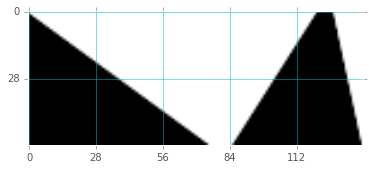

In [2]:
#Show iamge
IMG = Image.open("test_image.png")
plt.grid(c='c')
plt.xticks(np.arange(0,140,28))
plt.yticks(np.arange(0,56,28))
plt.imshow(np.asarray((IMG)))
print("image size:"+str(IMG.size))
img = Image.open("test_image.png").convert("L")

# 画像の切り出し関数

In [3]:
center_point_list = np.empty((1, 2))
for row in range(2):
    for col in range(5):
        c_point = (14+(28*col), 14*(row+1)+(row*14))
        center_point_list = np.vstack((center_point_list, c_point))
center_point_list = np.delete(center_point_list,0,0)

def cropImage(center_x, center_y, height, width):
    left = center_x - width/2
    upper = center_y - height/2
    right = center_x + width/2
    lower = center_y + height/2
    c_img = img.crop((left, upper, right, lower))
    carr = np.asarray(c_img)
    carr = carr.flatten()
    
    #print(c_img)
    carr = np.asarray(carr).astype(np.float32)
    return np.array(carr, dtype=np.float32)/255

def random_crop(DATA_NUM):
    image_list = np.empty(28*28,dtype=np.float32)
    labels = np.empty(2,dtype=np.int32)
    #print(image_list.size)
    for n in range(DATA_NUM):
        # choice 14 <= x <= 126 && 14 <= y <= 42
        randx = np.random.rand()*112 + 14
        randy = np.random.rand()*28 + 14
        c_image = cropImage(int(randx), int(randy), 28, 28)
        #print(c_image.shape)
        image_list = np.vstack((image_list, c_image))
        labels = np.vstack((labels,[randx, randy]))
    image_list = np.delete(image_list, 0,axis=0)
    labels = np.delete(labels,0, axis=0)
    return image_list, labels

def random_crop_in_area(left, upper, right, lower, label):
    image_list = np.empty(28*28,dtype=np.float32)
    randx = np.random.randint(left, right)
    randy = np.random.randint(upper, lower)
    crop_img = cropImage(randx, randy, 28, 28)
    return crop_img, label

def convert_axis(label, movement):
    m = movement
    p = center_point_list
    crop_area = []
    if label == 0:
        crop_area = (p[label][0], p[label][1], p[label][0]+m, p[label][1]+m)
    elif label == 1:
        crop_area = (p[label][0]-m, p[label][1], p[label][0]+m, p[label][1]+m)
    elif label == 2:
        crop_area = (p[label][0]-m, p[label][1], p[label][0]+m, p[label][1]+m)
    elif label == 3:
        crop_area =  (p[label][0]-m, p[label][1], p[label][0]+m, p[label][1]+m)
    elif label == 4:
        crop_area = (p[label][0]-m, p[label][1], p[label][0], p[label][1]+m)
    elif label == 5:
        crop_area =(p[label][0], p[label][1]-m, p[label][0]+m, p[label][1])
    elif label == 6:
        crop_area = (p[label][0]-m, p[label][1]-m, p[label][0]+m, p[label][1])
    elif label == 7:
        crop_area = (p[label][0]-m, p[label][1]-m, p[label][0]+m, p[label][1])
    elif label == 8:
        crop_area = (p[label][0]-m, p[label][1]-m, p[label][0]+m, p[label][1])
    else:
        crop_area = (p[label][0]-m, p[label][1]-m, p[label][0], p[label][1])
    return crop_area
'''
label=9
print(convert_axis(label,3))
print(center_point_list[label])
IMG = Image.open("test_image.png")
draw = ImageDraw.Draw(IMG)
for l in range(10):
    draw.rectangle((convert_axis(l,7)),fill=(0,129,129))
plt.xticks(np.arange(0,140,14))
plt.yticks(np.arange(0,56,14))
plt.imshow(np.asarray((IMG)))
#plt.clf()
#plt.imshow(img)
'''

'\nlabel=9\nprint(convert_axis(label,3))\nprint(center_point_list[label])\nIMG = Image.open("test_image.png")\ndraw = ImageDraw.Draw(IMG)\nfor l in range(10):\n    draw.rectangle((convert_axis(l,7)),fill=(0,129,129))\nplt.xticks(np.arange(0,140,14))\nplt.yticks(np.arange(0,56,14))\nplt.imshow(np.asarray((IMG)))\n#plt.clf()\n#plt.imshow(img)\n'

# 画像1枚の表示関数

In [4]:
def dispImage(img_vec, label):
    title = 'Label number is '+ str(label) 
    pixels = (img_vec * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.axis("off")
    plt.title(title)
    plt.show()

# 訓練データ生成

In [5]:
'''
train_one_class_data_num = 25
crop_area = 5
X_train = np.empty(28*28, dtype=np.float32)
L_train =np.empty(1,dtype=np.int32)
#print(L_train.shape)
for label in range(0,10):
    for c in range(0,train_one_class_data_num):
        left, upper, right, lower = convert_axis(label, crop_area)
        c_img, l = random_crop_in_area(left, upper, right, lower,label)
        X_train = np.vstack((X_train, c_img))
        L_train = np.vstack((L_train, l))
X_train = np.delete(X_train, 0,axis=0)
L_train = np.delete(L_train, 0,axis=0)

train_cnt = len(X_train)
l_train_half = np.concatenate([L_train[0:(train_cnt/2)], np.ones((train_cnt-(train_cnt/2),1))*(-1)]).astype('int32')
l_train_half = np.ravel(l_train_half)
print(l_train_half.dtype)

test_one_class_data_num = 20
X_test = np.empty(28*28, dtype=np.float32)
L_test =np.empty(1,dtype=np.int32)
for label in range(0,10):
    for c in range(0,test_one_class_data_num):
        left, upper, right, lower = convert_axis(label, crop_area)
        c_img, l = random_crop_in_area(left, upper, right, lower,label)
        X_test = np.vstack((X_test, c_img))
        L_test = np.vstack((L_test, l))
X_test = np.delete(X_test, 0,axis=0)
L_test = np.delete(L_test, 0,axis=0)
L_test = np.ravel(L_test)

#  list : [image label]  
Xy_train = [(x, y) for x, y in zip(X_train, l_train_half)]
Xy_test = [(x, -1) for x, y in zip(X_test, L_test)]
'''
train_im, train_la = random_crop(5000)
test_im, test_la = random_crop(300)
X_train = train_im
L_train = train_la.astype('float32')
X_test = test_im
L_test = test_la.astype('float32')
train_cnt = len(X_train)
Xy_train = [(x, y) for x, y in zip(X_train, L_train)]
Xy_test = [(x, -1) for x, y in zip(X_test, L_test)]


# 訓練データの確認

****************0***********************


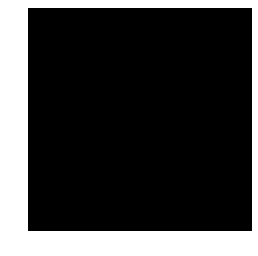

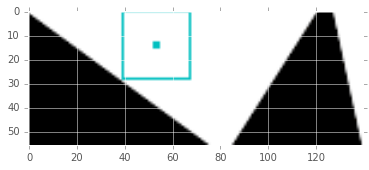

****************1***********************


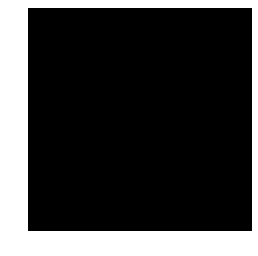

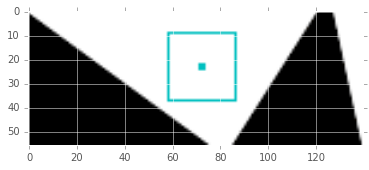

****************2***********************


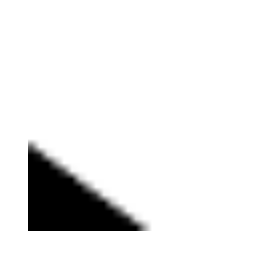

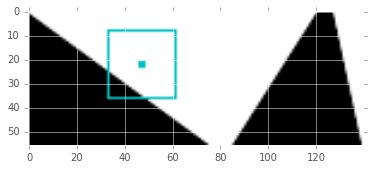

In [6]:
t_img = Image.open("test_image.png")
def dispTrainData(img_list, label_list):
    for c in range(len(img_list)):
        print("****************{}***********************".format(c))
        plt.clf()
        img = t_img.copy()
        x = label_list[c][0]
        y = label_list[c][1]
        pixels = (img_list[c] * 256).reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.axis("off")
        plt.show()
        draw = ImageDraw.Draw(img)
        draw.ellipse((x-1, y-1, x+1, y+1), (0,192,192), (0,192,192))
        draw.rectangle([(x-14,y-14),(x+14,y+14)],outline=(0,192,192))
        plt.imshow(img)
        plt.show()

dispTrainData(X_train[0:3], L_train[0:3])


In [ ]:
def train(input_size, hidden_size, z_size, label_size, minibatch_size, epoch_num, X_train, output):
    model = CVAE(input_size, z_size, hidden_size, label_size)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)
    
    train_iter = chainer.iterators.SerialIterator(X_train, minibatch_size)
    for epoch in range(0, epoch_num):
        sum_loss = 0
        sum_rec_loss = 0
        batch = train_iter.next()
        x_array, t_array = convert.concat_examples(batch)
        x = chainer.Variable(x_array)
        t = chainer.Variable(t_array)
        optimizer.update(model.get_loss_func(C=0.1, k=5), x, t)
        
        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)
        
    chainer.serializers.save_npz(output, model)
    print('train mean loss={}, mean reconstruction loss={}'.format(sum_loss / train_cnt, sum_rec_loss / train_cnt))

def test_plot(model, X_test, L_test):
    colors_dict = {}
    markers = ["*", "s", "v", "^", "8", "o", "p", "D", "p", "d"]
    cm = plt.get_cmap('jet')
    for dic in range(0,10):
        colors_dict[dic] = cm(1.*dic/10)
        train_iter = chainer.iterators.SerialIterator(X_test, len(X_test), repeat=False, shuffle=False)
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        batch = train_iter.next()
        x_array, t_array = convert.concat_examples(batch)
        x = chainer.Variable(x_array)
        t = chainer.Variable(t_array)
        x_mu, log_var = model.encode(x, t)
        print('mu size:{}'.format(x_mu.shape))
        print('logvar size:{}'.format(log_var.shape))
    data_dict = {}
    for x, y in zip(x_mu.data, L_test):
        if y in data_dict:
            data_dict[y].append(x)
        else:
            data_dict[y] = [x]
    plt.axes(axisbg='w')
    for y in range(0, 10):
        data = data_dict[y]
        xs  = [row[0] for row in data]
        ys = [row[1] for row in data]
        plt.scatter(xs, ys, s=150, c=colors_dict[y],marker=markers[y], label=y)
    plt.title("CVAE")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=13)
    plt.grid()
    
def test_decode(model, x, label, output):
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        x_v = chainer.Variable(x)
        label_v = chainer.Variable(label)
        y_v = model(x_v, label_v)
        print('出力')
        pixels = (y_v.data * 256).reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.axis("off")
        plt.show()
        #plt.imsave(output, pixels, cmap='gray')

# 訓練

In [ ]:
#main
EPOCH_NUM = 1000
INPUT_SIZE = 784
HIDDEN_SIZE = 128
MINIBATCH_SIZE = 100
LABEL_SIZE = 2
Z_SIZE = 2

scores = {}
MODEL_PATH = './CVAE_{0}_{1}.model'.format(EPOCH_NUM, Z_SIZE)

train(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    z_size=Z_SIZE,
    label_size=LABEL_SIZE,
    minibatch_size=MINIBATCH_SIZE,
    epoch_num=EPOCH_NUM,
    X_train=Xy_train,
    output=MODEL_PATH
)

# 訓練した重みを使って文字を生成

In [ ]:
from defCVAE import CVAE
'''
INPUT_SIZE = 784
HIDDEN_SIZE = 128
Z_SIZE = 2
MINIBATCH_SIZE = 100
LABEL_SIZE = 2
'''
MODEL_PATH = './CVAE_{0}_{1}.model'.format(EPOCH_NUM, Z_SIZE)

model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)
chainer.serializers.load_npz(MODEL_PATH, model)

index = 7
print('入力')
pixels = (Xy_test[index][0] * 256).reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.axis("off")
plt.show()

test_decode(model, X_test[[index]], np.array(L_test[[index]], dtype='float32'), MODEL_PATH )

# 画像が潜在空間のどこに分布しているのか表示

In [ ]:
'''
INPUT_SIZE = 784
HIDDEN_SIZE = 128
Z_SIZE = 2
MINIBATCH_SIZE = 100
LABEL_SIZE = 2
MODEL_PATH = './CVAE_1000_2.model'
model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)
chainer.serializers.load_npz(MODEL_PATH, model)
test_plot(model, X_test[0:len(L_test)], L_test[0:len(L_test)])
'''

In [ ]:
'''
nx = ny = 3
x_values = np.linspace(-2, 2, nx)
y_values = np.linspace(-2, 2, ny)

cnt = 0
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        #print("\r cnt={}/{}".format(cnt, nx*ny), end=""); cnt += 1
        # draw images from randomly sampled z
        z = chainer.Variable(np.array([[xi, yi]], dtype=np.float32)) 
        x_mean = model.decode(z,np.array([[14,14]], dtype='float32'),True)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = (x_mean*255).data.astype(np.int32).reshape(28,28)
        
canvas_cpu = chainer.cuda.to_cpu(canvas)

plt.figure(figsize=(10, 15))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas_cpu, origin="upper", cmap="gray")
plt.tight_layout()
plt.savefig("mapping.png")


nx = ny = 30
x_values = np.linspace(-2, 2, nx)
y_values = np.linspace(-2, 2, ny)

cnt = 0
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        #print("\r cnt={}/{}".format(cnt, nx*ny), end=""); cnt += 1
        # draw images from randomly sampled z
        z = chainer.Variable(np.array([[xi, yi]], dtype=np.float32)) 
        x_mean = model.decode(z,np.array([[70,14]], dtype='float32'),True)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = (x_mean*255).data.astype(np.int32).reshape(28,28)
        
canvas_cpu = chainer.cuda.to_cpu(canvas)

plt.figure(figsize=(10, 15))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas_cpu, origin="upper", cmap="gray")
plt.tight_layout()
plt.savefig("mapping.png")
'''
z = chainer.Variable(np.array([[0, 0]], dtype=np.float32)) 
for p1 in range(14,126,10):
    for p2 in range(14,42,10):
        x_mean = model.decode(z,np.array([[p1,p2]], dtype='float32'),True)
        x_mean = np.reshape(x_mean.data, (28,28))
        print(p1)
        print(p2)
        dispImage(x_mean,-1)